
#  SENTIMENT ANALYSIS PROJECT - FULL NOTEBOOK



In [1]:
import numpy as np
import pandas as pd

import re
import string

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from collections import Counter

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    classification_report, 
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    precision_recall_curve, 
    accuracy_score
)
import joblib

#### 2. Load Dataset

In [3]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate() 

api.dataset_download_files('lakshmi25npathi/imdb-dataset-of-50k-movie-reviews', path='.', unzip=True)

df = pd.read_csv('IMDB Dataset.csv')
df.head()


Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.shape

(50000, 2)

#### 3. Inspect & Clean Data

In [5]:
df.info()
print("____________________________________")
print(df['sentiment'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
____________________________________
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


###### Converting positive to 1 and negative to 0

In [6]:
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

#### 4. Text Preprocessing

In [7]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    # strip URLs and HTML fragments to reduce noise
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

df['clean_text'] = df['review'].apply(clean_text)
df[['review', 'clean_text']].head()

,review,clean_text
0,One of the other reviewers has mentioned that ...,one reviewers mentioned watching oz episode ho...
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,basically family little boy jake thinks zombie...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter mattei love time money visually stunnin...


#### 5. EDA and Visualizations

###### 5.1 Sentiment Distribution

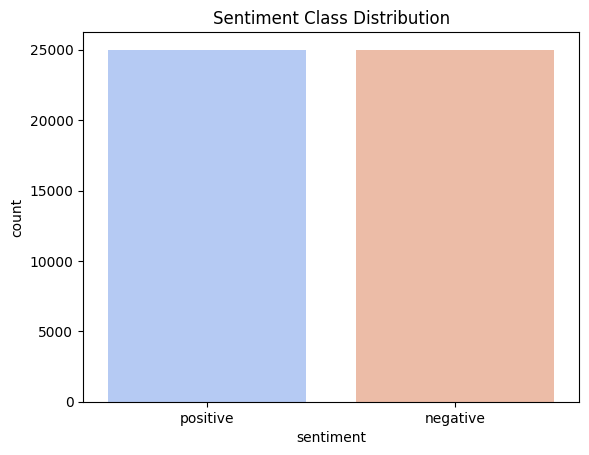

In [8]:
plt.title("Sentiment Class Distribution")
sns.countplot(x='sentiment', hue='sentiment', data=df, palette='coolwarm', legend=False)
plt.show()

###### 5.2 WordClouds

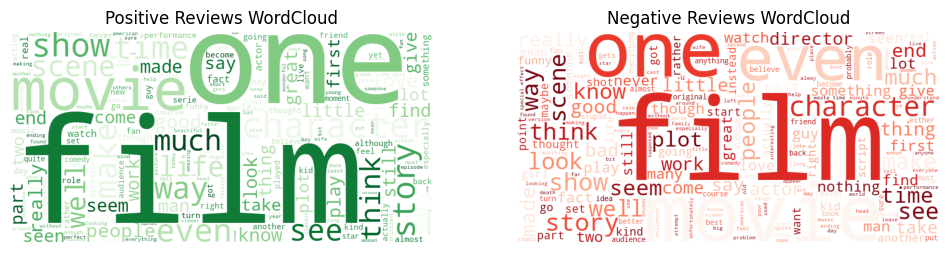

In [9]:
positive_text = ' '.join(df[df['label']==1]['clean_text'])
negative_text = ' '.join(df[df['label']==0]['clean_text'])

wc_pos = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_text)
wc_neg = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_text)


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(wc_pos)
plt.axis('off')
plt.title("Positive Reviews WordCloud")

plt.subplot(1, 2, 2)
plt.imshow(wc_neg)
plt.axis('off')
plt.title("Negative Reviews WordCloud")

plt.show()

###### 5.3 Most Common Words

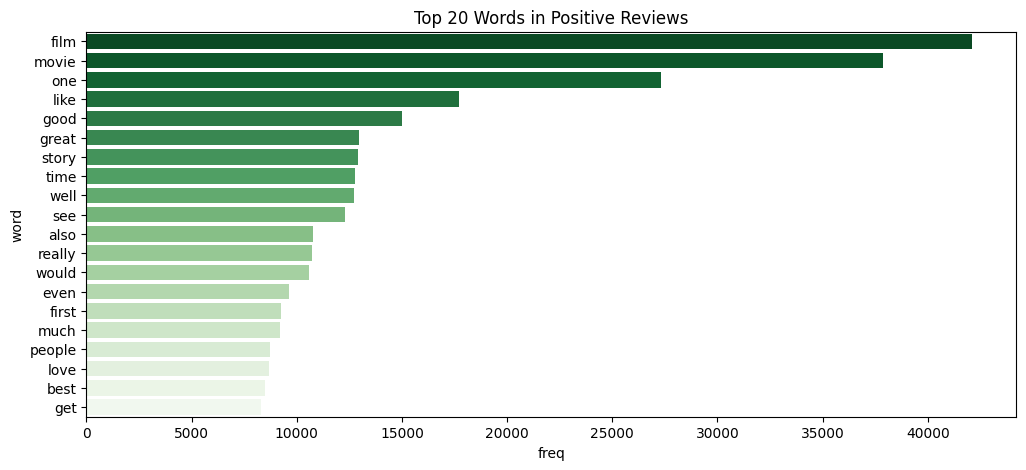

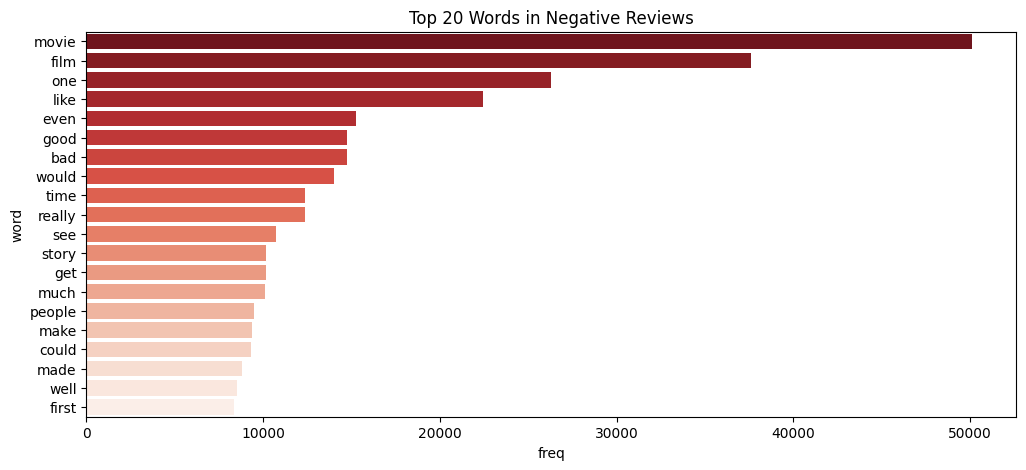

In [10]:
# Compute most common words in positive and negative reviews where most_common function is used to get the top 20 words
pos_counts = Counter(" ".join(df[df['label']==1]['clean_text']).split()).most_common(20)
neg_counts = Counter(" ".join(df[df['label']==0]['clean_text']).split()).most_common(20)


pos_df = pd.DataFrame(pos_counts, columns=['word', 'freq'])
neg_df = pd.DataFrame(neg_counts, columns=['word', 'freq'])

plt.figure(figsize=(12, 5))
sns.barplot(x='freq', y='word', hue='word', data=pos_df, palette='Greens_r', legend=False)
plt.title("Top 20 Words in Positive Reviews")
plt.show()

plt.figure(figsize=(12, 5))
sns.barplot(x='freq', y='word', hue='word', data=neg_df, palette='Reds_r', legend=False)
plt.title("Top 20 Words in Negative Reviews")
plt.show()

#### 6. Vectorization (TF-IDF)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['label'], test_size=0.2, stratify=df['label'], random_state=42
)

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
print("=========================================================================")
print("Training data shape:", X_train_tfidf.shape)
print("Test data shape:", X_test_tfidf.shape)

Training data shape: (40000, 10000)
Test data shape: (10000, 10000)


#### 7. Model Training

###### Logistic Regression

In [12]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)

y_pred_lr = lr.predict(X_test_tfidf)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("__________________________________________________________________")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.8984
__________________________________________________________________
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      5000
           1       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



###### SVM (LinearSVC)

In [13]:
svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)

y_pred_svm = svm.predict(X_test_tfidf)
print("Linear SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("_______________________________________________________________")
print(classification_report(y_test, y_pred_svm))

Linear SVM Accuracy: 0.8899
_______________________________________________________________
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      5000
           1       0.89      0.89      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



#### 8. Evaluation Visualization

###### Confusion Matrix (for Logistic Regression)

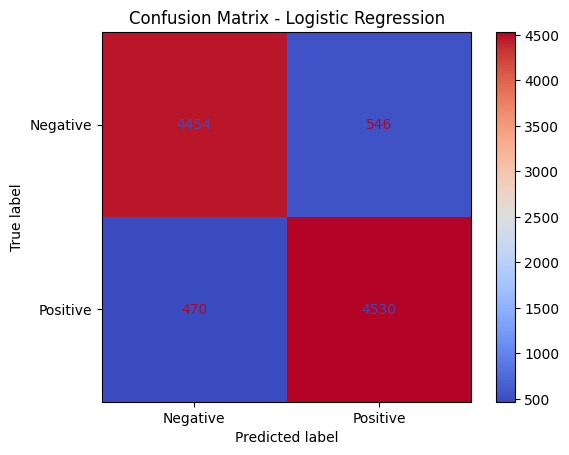

In [14]:
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap="coolwarm")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

###### ROC Curve

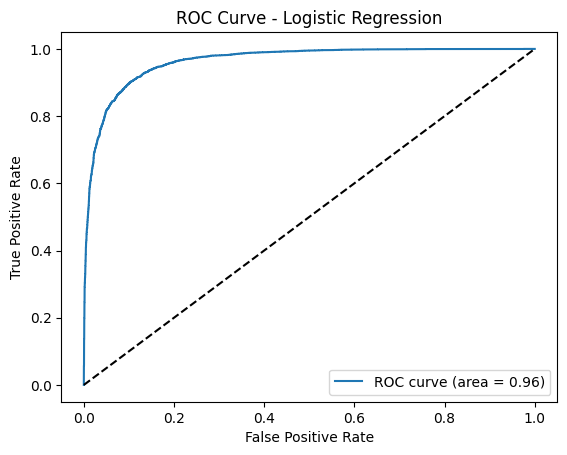

In [15]:
y_prob_lr = lr.predict_proba(X_test_tfidf)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.show()

###### Precision-recall Curve

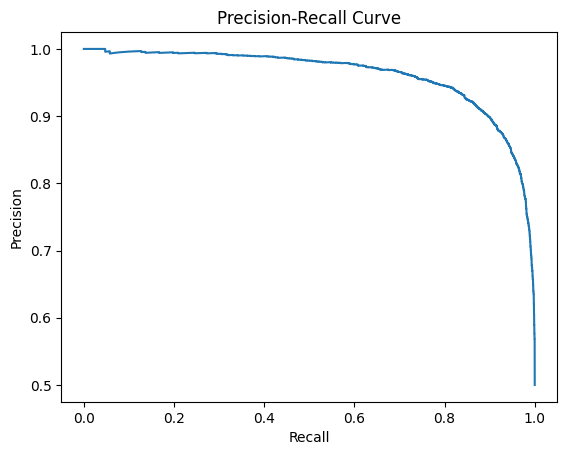

In [16]:
prec, rec, _ = precision_recall_curve(y_test, y_prob_lr)

plt.plot(rec, prec, label='Precision-Recall')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

#### 9. Save Model and Vectorizer

In [17]:
joblib.dump(lr, 'sentiment_model.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')

print("Model and Vectorizer saved successfully!")

Model and Vectorizer saved successfully!


#### 10. Inference Example

In [18]:
loaded_model = joblib.load('sentiment_model.pkl')
loaded_vectorizer = joblib.load('vectorizer.pkl')

sample = ["The movie was absolutely amazing, I loved it so much!", "I don't like bollywood movies!"]
sample_vec = loaded_vectorizer.transform(sample)
pred = [loaded_model.predict(sample_vec)[0], loaded_model.predict(sample_vec)[1]]

print(f"Prediction 1[{sample[0]}]:", "Postive" if pred[0]==1 else "Negative")
print(f"Prediction 2[{sample[1]}]:", "Postive" if pred[1]==1 else "Negative")

Prediction 1[The movie was absolutely amazing, I loved it so much!]: Postive
Prediction 2[I don't like bollywood movies!]: Negative
